In [187]:
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import numpy as np
from langdetect import detect
import re

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist

from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

# About
#### Can a computer can tell the genre of a song based on his lyrics? <br>

My goal is to build a model that can predict from 4 different genre, the genre of a song based on his lyrics. <br>
The genres i decided to focus on are Rock, Hip Hop, Soul and Reggae. <br>
I am using the "bag of words" approach, wish is building a model based on words frequencies in the corpus.

## Acknoledgement
I got the data from the brazilian website:   www.vagalume.com.br <br> 
A great website with plenty of lyrics organized by genre.

# Getting the data
My first step was to get the data. <br>
The next function crawl the website using 'requests' and 'BeautifulSoup'.

In [ ]:
def crawler(base_url, genre_url, genre):
    
    # to store the data:
    artists = [] 
    songs_name = []
    lyrics = []
    
    # from the genre page i get to the artists page,
    # then from the artists page i get to each lyrics of that artist:
    
    genre_page_html = requests.get(genre_url)
    time.sleep(3)
    soup = BeautifulSoup(genre_page_html.content,'html.parser') 
    artists_list = soup('ul', attrs={'class':'namesColumn'})
    artists_href = []
    for i in range(len(artists_list)):
        artists_href+= [t['href'] for t in artists_list[i]('a')]    
    urls_to_artists = [base_url+href for href in artists_href]
    
    for i in range(len(urls_to_artists)):
        try:
            artist_page_html = requests.get(urls_to_artists[i])
            time.sleep(3)
            soup = BeautifulSoup(artist_page_html.content, 'html.parser')
            songs_html = soup.find(id='alfabetMusicList')
            songs_href = [t['href'] for t in songs_html.findAll(class_='nameMusic')]
            urls_to_songs = [base_url+href for href in songs_href]
        except:
            continue       
        for url in urls_to_songs:
            try:
                song_page_html = requests.get(url)
                time.sleep(3)
                soup = BeautifulSoup(song_page_html.content, 'html.parser')
                song_name = soup.find(id='lyricContent')('h1')[0].get_text()
                artist = soup.find(id='lyricContent')('h2')[0].get_text()
                lyrics_ = soup.find(id='lyrics').get_text("\n")
            except:
                continue   
            songs_name.append(song_name)
            artists.append(artist)
            lyrics.append(lyrics_)
            
        if(i%5==0): # every 5 artists i store the data in the hard disk
            df = pd.DataFrame({'Artist': artists, 'Song': songs_name, 'Lyrics': lyrics, 'Genre': genre })
            df.to_csv(str(genre)+'.csv')
    df = pd.DataFrame({'Artist': artists, 'Song': songs_name, 'Lyrics': lyrics, 'Genre': genre })
    df.to_csv(str(genre)+'.csv')

In [ ]:
base_url = 'https://www.vagalume.com.br'
crawler(base_url, 'https://www.vagalume.com.br/browse/style/rock.html', 'Rock')
crawler(base_url, 'https://www.vagalume.com.br/browse/style/reggae.html', 'Reggae')
crawler(base_url, 'https://www.vagalume.com.br/browse/style/hip-hop.html', 'Hip Hop')
crawler(base_url, 'https://www.vagalume.com.br/browse/style/soul-music.html', 'Soul')

In [215]:
df1 = pd.read_csv('Soul.csv', index_col=[0])
df2 = pd.read_csv('hip_hop.csv', index_col=[0])
df3 = pd.read_csv('reggae.csv', index_col=[0])
df4 = pd.read_csv('rock.csv', index_col=[0])
df= pd.concat([df1,df2,df3,df4], ignore_index=True)
df.to_csv('row_data.csv')
df.shape

(38334, 4)

It took me a couple of days to get all the data i needed, but now i have a dataframe of almost 40,000 lyrics <br>

# Data cleaning
Now its time to clean the data. <br>
As a brazilian website vagalume has many brazilian songs. <br>
I filter the lyrics by keeping english lyrics only.<br>
I use a language detecter from python lybraries.

In [216]:
for i in df.index:
    if detect(df['Lyrics'][i])!='en':
        df.drop(i, inplace=True)       
df.reset_index(drop=True, inplace=True)

df.shape

(26580, 4)

It takes a few minute to finish the language detection so i save the file after it.<br>

In [222]:
df1 = pd.read_csv('just_english_lyrics1.csv', index_col=[0])
df2 = pd.read_csv('just_english_lyrics2.csv', index_col=[0])
df = pd.concat([df1,df2], ignore_index=True)
df.shape

(26580, 4)

I noticed there are couple of artists with multiple labels. <br>
I decided to get ride of them.

In [217]:
for artist in df['Artist'].unique():
    if len(df[df['Artist']==artist]['Genre'].unique())>1: #if artist has more than one label
        df.drop(df[df['Artist']==artist].index, inplace=True)
        
df.reset_index(drop=True, inplace=True)
df.shape

(24375, 4)

I might have empty lyrics or duplicated ones.

In [206]:
df.drop(df[df['Lyrics']==''].index, inplace=True) #drop empty cells in Lyrics column
df.drop_duplicates(subset=['Lyrics'], inplace=True) #drop duplicates in Lyrics column
for i in df.index:
    if type(df['Lyrics'][i]) is not str:
        df.drop(i, inplace=True)
df.shape

(23894, 4)

I am also removing sentences in the lyrics that are within brackets. 

In [207]:
for i in df.index:
    df['Lyrics'][i] = re.sub(r'\[[^()]*\]', '',df['Lyrics'][i])

### tokenization
For every lyrics in the dataframe i am applying a word tokenizer, which breaks a text into a list of words. <br>
I first check that the token is only letters. (numbers are not very informative)<br>
I then check if the token is not a stop word.<br>
If not i am keeping the root base of the word using a lemmatizer.<br>
(i add a list of words to remove, i noticed they create some noise in the model) 

A text before cleaning:

In [208]:
df['Lyrics'][5]

"The fish swam out of the ocean\nAnd grew legs and they started walking\nAnd the apes climbed down from the trees\nAnd grew tall and they started talking\nAnd the stars fell out of the sky\nAnd my tears rolled into the ocean\nNow I'm looking for a reason why\nYou even set my world into motion\n'Cause if you're not really here\nThen the stars don't even matter\nNow I'm filled to the top with fear\nBut it's all just a bunch of matter\n'Cause if you're not really here\nThen I don't want to be either\nI wanna be next to you\nBlack and gold\nBlack and gold\nBlack and gold\nI looked up into the grey sky\nAnd see a thousand eyes staring back\nAnd all around these golden beacons\nI see nothing but black\nI feel a way of something beyond them\nI don't see what I can feel\nIf vision is the only validation\nThen most of my life isn't real\n'Cause if you're not really here\nThen the stars don't even matter\nNow I'm filled to the top with fear\nBut it's all just a bunch of matter\n'Cause if you're 

In [209]:
stop_words_list = pd.read_json('stop_words_english.json')[0].tolist() #this is an expanded list of stop words i found online

lemmatizer = WordNetLemmatizer()

unwanted_words = stop_words_list + ['eye','ta','as','em', 'fi', 'mind', 'girl', 'yeah', 'night', 'heart', 'eye', 'day','feel', 'baby', 'life', 'man','love','time', 'ah','aah', 'aaah', 'ai', 'wo', 'dem', 'wan', 'mi', 'di', 'gon', 'chorus']
wanted_words=[]

for i in df.index:
    tokens = word_tokenize(df['Lyrics'][i])
    for token in tokens:
        if token.isalpha() and len(token)>1 and token.lower() not in unwanted_words:
            wanted_words.append(lemmatizer.lemmatize(token.lower()))       
    df['Lyrics'][i] = ' '.join(wanted_words)
    wanted_words.clear()
    
df.drop(df[df['Lyrics']==''].index, inplace=True) #drop empty cells in Lyrics column
df.drop_duplicates(subset=['Lyrics'], inplace=True) #drop duplicates in Lyrics column
# df.to_csv('clean_data.csv')

After cleaning: 

In [210]:
df['Lyrics'][5]

'fish swam ocean grew leg started walking ape climbed tree grew tall started talking star fell sky tear rolled ocean reason set motion star matter filled fear bunch matter black gold black gold black gold looked grey sky eye staring golden beacon black vision validation real star matter filled fear bunch matter black gold black gold black gold'

In [211]:
df = pd.read_csv('clean_data.csv', index_col=[0])

df.describe(include='all')

,Artist,Song,Lyrics,Genre
count,23767,23767,23767,23767
unique,862,21035,23767,4
top,Prince,Intro,morning rain uninspired knew face lord tired m...,Rock
freq,561,16,1,7793


In [212]:
df['Genre'].value_counts()

Rock       7793
Soul       7538
Hip Hop    5971
Reggae     2465
Name: Genre, dtype: int64

In [213]:
df['Artist'].value_counts().head(20)

Prince                  561
Diana Ross              348
Ray Charles             313
Michael Jackson         296
Stevie Wonder           247
The Supremes            227
Aretha Franklin         211
Alicia Keys             207
Jackson 5               204
Chaka Khan              200
Norah Jones             191
UB40                    188
Earth, Wind And Fire    187
Al Green                180
Bob Marley              177
Marvin Gaye             173
Sam Cooke               166
Ziggy Marley            163
Luther Vandross         157
Tina Turner             147
Name: Artist, dtype: int64

# Vizualization
The corpus should be quit clean now. <br>
Let see "frequent words" plots by genre using matplotlib.

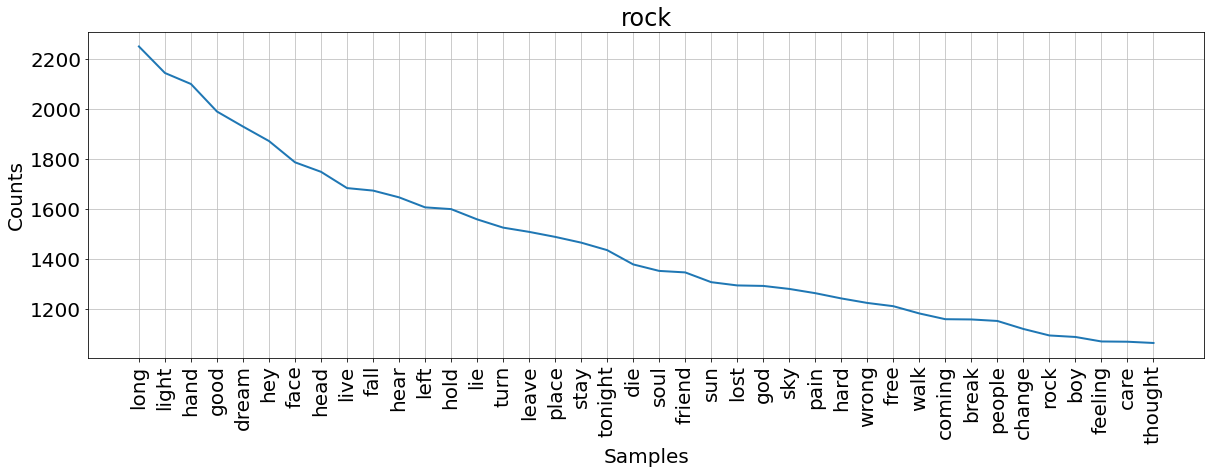

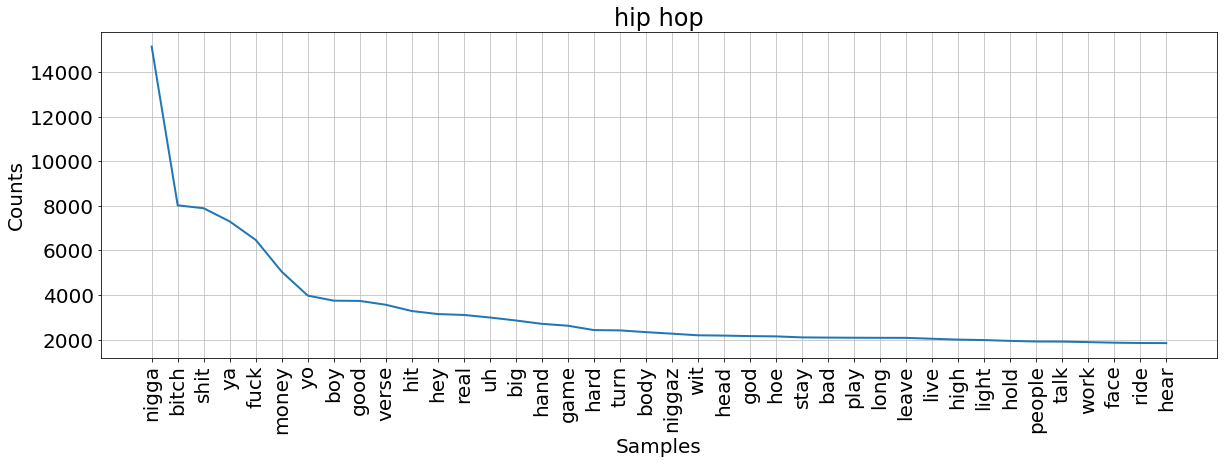

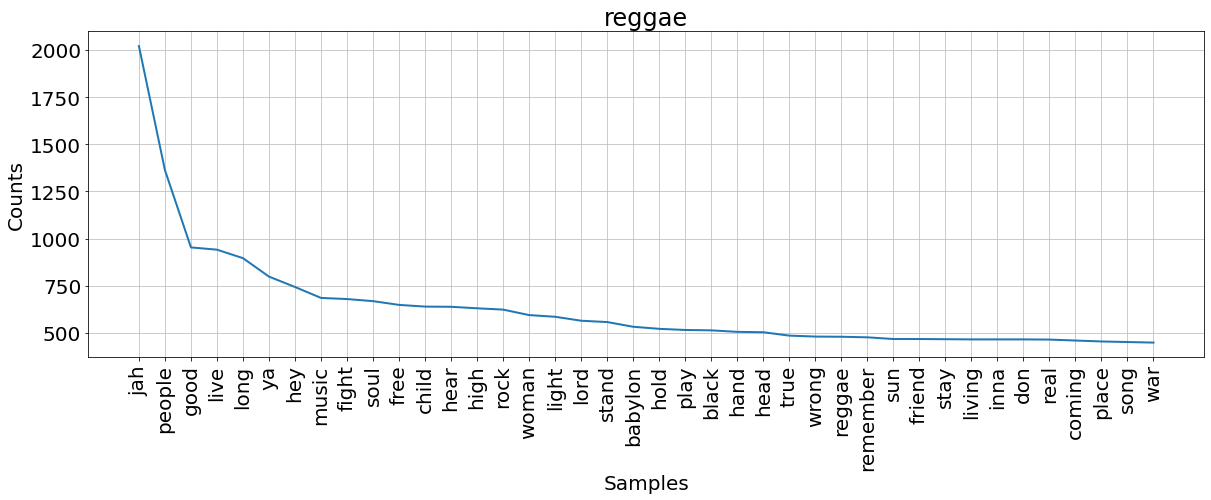

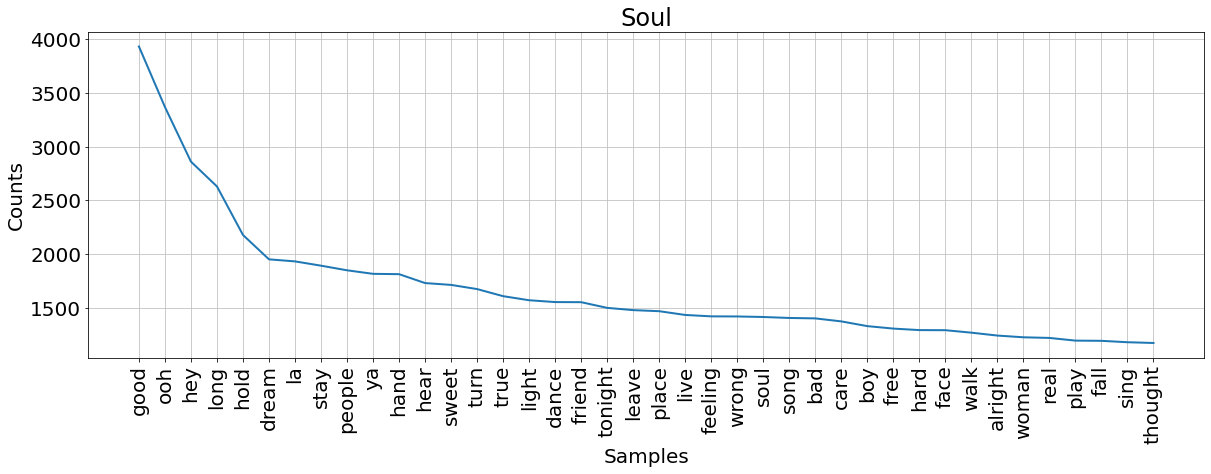

<AxesSubplot:title={'center':'Soul'}, xlabel='Samples', ylabel='Counts'>

In [198]:
rock_words = ' '.join(df[df['Genre']=='Rock']['Lyrics'])
hip_hop_words = ' '.join(df[df['Genre']=='Hip Hop']['Lyrics'])
soul_words = ' '.join(df[df['Genre']=='Soul']['Lyrics'])
reggae_words = ' '.join(df[df['Genre']=='Reggae']['Lyrics'])

fdist_rock = FreqDist(rock_words.split(' '))
fdist_hip_hop = FreqDist(hip_hop_words.split(' '))
fdist_reggae = FreqDist(reggae_words.split(' '))
fdist_soul = FreqDist(soul_words.split(' '))

plt.rcParams.update({'font.size': 20})
plt.subplots(figsize=(20, 6))
fdist_rock.plot(40, title='rock')
plt.subplots(figsize=(20, 6))
fdist_hip_hop.plot(40, title='hip hop')
plt.subplots(figsize=(20, 6))
fdist_reggae.plot(40, title='reggae')
plt.subplots(figsize=(20, 6))
fdist_soul.plot(40, title='Soul')

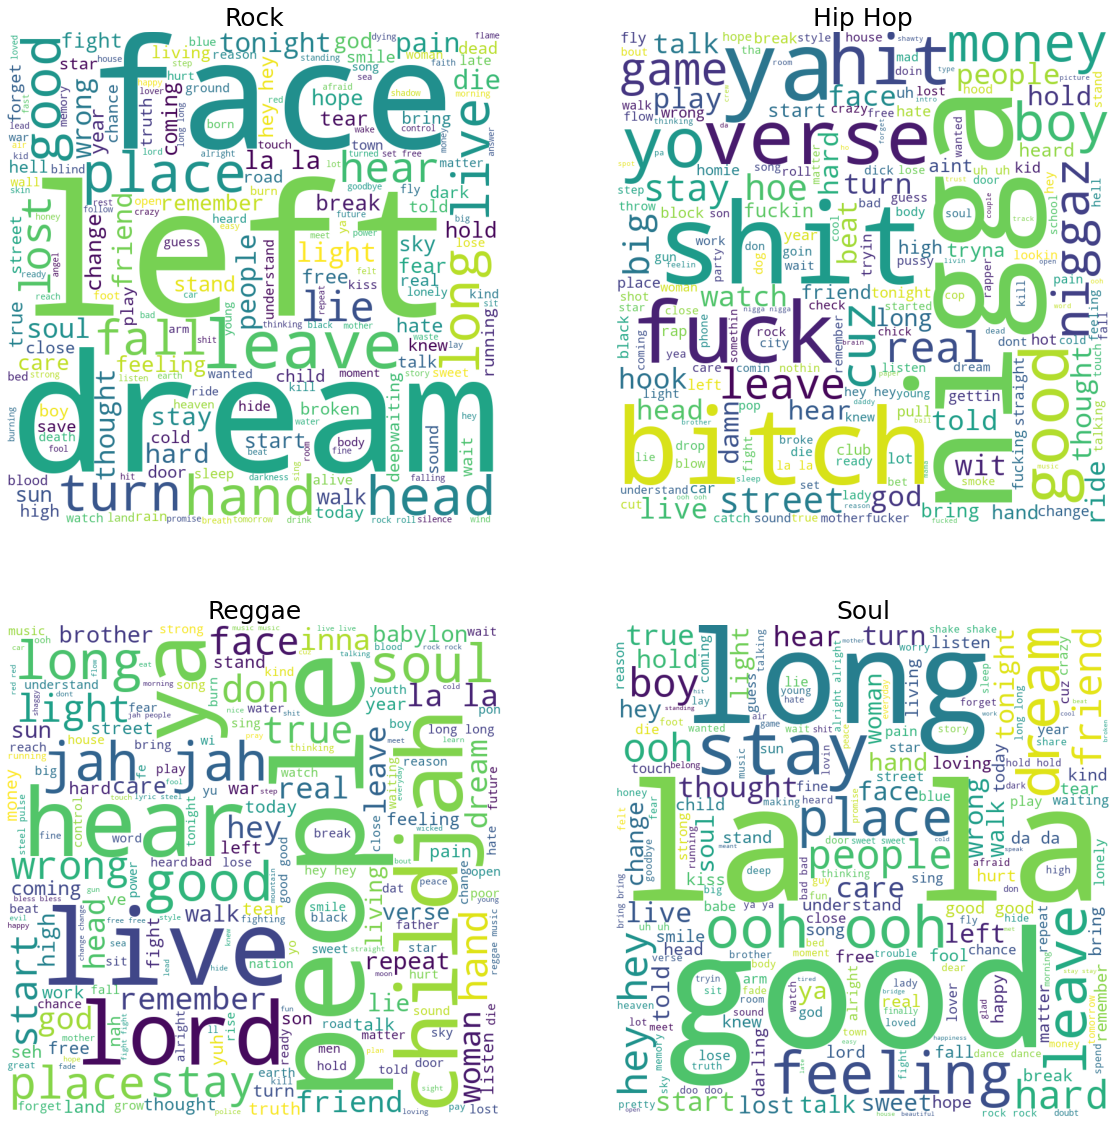

In [199]:
words_list = [rock_words,hip_hop_words,reggae_words,soul_words]
genres = ['Rock','Hip Hop','Reggae','Soul']

plt.figure(figsize=(20,20)) 
for i in range(1, 5):
    wordcloud = WordCloud(width = 800, height = 800,background_color='white', min_font_size = 10).generate(words_list[i-1]) 
    plt.subplot(2, 2, i)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(genres[i-1],fontsize=25)
    
plt.show()

# Vectorization
Now it's time to vectorize the lyrics such that the columns are words and each cell reprensents the TF-IDF (Term Frequency — Inverse Document Frequency) of a specific word from the text.<br>
This is performed by looking at how many times a word appears into a document while taking into consideration how many times the same word appears in other documents in the corpus.

Let's convert the labels to numerical as below:

In [200]:
y = df['Genre']
y[y=='Rock']=1
y[y=='Hip Hop']=2
y[y=='Reggae']=3
y[y=='Soul']=4
print(y.value_counts())
y = y.tolist()

1    7793
4    7538
2    5971
3    2465
Name: Genre, dtype: int64


I am keeping the words that appears at least in 18 differents lyrics and no more than 0.7 percent of the lyrics.

In [201]:
vec = TfidfVectorizer(min_df=18, max_df=0.7)
X = vec.fit_transform(df['Lyrics'])
df_vec = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

In [202]:
df_vec.shape

(23767, 6718)

# Train and test
The final step is to split the dataframe into train and test. <br>
I use the SGD Classifier to build the model. It is a linear classifier optimized by Stochastic Gradient Descent.<br>
After trying different algorithms, i got the best scores with this one. 

In [203]:
X_train, X_test, y_train, y_test = train_test_split(df_vec, y , test_size=0.3, random_state=42, shuffle=True)
clf = SGDClassifier()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print(classification_report(y_test, y_predict, target_names=['Rock','Hip Hop','Reggae','Soul']))

              precision    recall  f1-score   support

        Rock       0.63      0.69      0.66      2349
     Hip Hop       0.82      0.76      0.79      1825
      Reggae       0.81      0.43      0.56       742
        Soul       0.60      0.67      0.64      2215

    accuracy                           0.68      7131
   macro avg       0.72      0.64      0.66      7131
weighted avg       0.69      0.68      0.68      7131



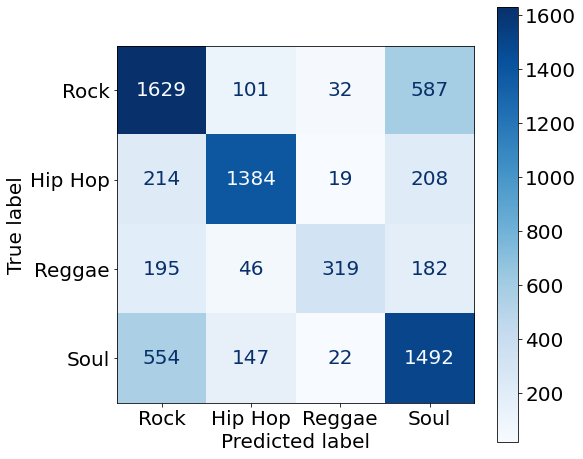

In [204]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test, y_predict)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Rock', 'Hip Hop','Reggae', 'Soul'])
cmd.plot(ax=ax, cmap='Blues')

I got an  overall accuracy of 0.68.<br>
We can see that the model succeed to differe quite good between the Hip Hop and Reggae genres. <br>
But there is still work to do with the lyrics of Rock and Soul. The model labeled many Rock songs as Soul and vice versa.

There is still some improvements to do but we can see than in every genre the model predicted correctly most of the songs. and that it actualy works. <br>
Thank you for watching :)